# GAN For Face Detection

## Importing

In [1]:
from torchvision.datasets import CelebA, ImageFolder
import torchvision.transforms as ttran

## Hyperparameters

In [46]:
IMG_SIZE = 300
IMGS_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/'
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
BATCH_SIZE = 20

## Transform

In [3]:
train_transform = ttran.Compose([ttran.Resize((300, 300)), ttran.PILToTensor()])
test_transform = ttran.Compose([ttran.Resize((300, 300)),ttran.PILToTensor()])

## Dataset

In [4]:

#train_ds = CelebA('/kaggle/working/data/', split='train', download=True, transform=train_transform)
#test_ds = CelebA('/kaggle/working/data/', split='test', download=True, transform=test_transform)

ds = ImageFolder(IMGS_PATH, train_transform)

import torch

# Lowering dataset (for testing reasons)
ds = torch.utils.data.Subset(ds, range(300))


In [5]:
img, label = ds[0]

## Arquitetura do Modelo

### MLP GAN
Iniciaremos uma MLP GAN, a qual tem ambos o gerador e o discriminador sendo compostos apenas por camadas densas.

### DCGAN
O modelo será composto por dois blocos principais:
- gerador: uma CNN treinada para gerar imagens ao invés de classificá-las (usa camadas convolucionais transpostas, para fazer o caminho inverso). Usará perda em conjunto com o discriminador.
- discriminador: uma CNN treinada em comparação com o dataset (CelebA) para classificação binária (é um item do dataset ou não). Usará perda focada no discriminador apenas.


Existem outras redes GANs, como GANs condicionais que, ao que aparentam, recebem como entrada um dado adicional (não apenas ruído).

## Criação do Modelo

### Gerador

In [ ]:
from torch import nn
import torch

class Generator(nn.Module):

    def __init__(self, num_features, output_size=300):
        """
            - *num_features*: generator input size
            - *output_size*: image size (for square RGB images)
        """
        super().__init__()
        self.output_size = output_size
        flattened_img_size = output_size*output_size*3

        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, flattened_img_size),
            nn.Sigmoid()
        )


    def forward(self, input):
        img = self.layers(input)
        reshaped_img = img.reshape(-1, 3, self.output_size, self.output_size) # (B, C, H, W) # batches, channels, height, width
        reshaped_img = reshaped_img * 255 # values are between 0 and 1, so we multiply by 255 to make them rgb values.
        return reshaped_img

In [7]:
generator = Generator(100, 300) # Creating Generator

#### Gerando Imagem Aleatória

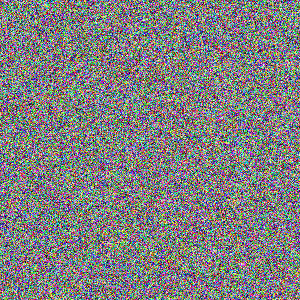

In [8]:
from torchvision.transforms.functional import to_pil_image

result = generator(torch.rand(3, 100))

display(to_pil_image(result[0]))

### Discriminador

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, img_size):
        """
            - *img_size*: image size (for square RGB images)
        """
        super().__init__()
        flattened_img_size = img_size*img_size*3

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_img_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            #nn.Sigmoid()
        )


    def forward(self, img):

        img = img / 255
        output = self.layers(img)

        return output

In [10]:
discriminator = Discriminator(IMG_SIZE)

#### Testando discriminador

In [ ]:
result.shape

torch.Size([3, 3, 300, 300])

In [12]:
discriminator(result)

tensor([[-0.0845],
        [-0.0845],
        [-0.0845]], grad_fn=<AddmmBackward0>)

## GAN

In [13]:
class GAN(nn.Module):

    def __init__(self, noise_size=100, img_size=300):
        """
            - *img_size*: image size (for square RGB images)
        """
        super().__init__()

        self.generator = Generator(noise_size, img_size)
        self.discriminator = Discriminator(img_size)

    def forward(self, noise_input):

        gen_output = self.generator(noise_input)
        final_output = self.discriminator(gen_output)

        return gen_output, final_output

In [14]:
model = GAN()

## Treinamento

## Auxiliares

In [ ]:
disc_optim = torch.optim.RMSprop(model.discriminator.parameters(), lr=LEARNING_RATE)
gen_optim = torch.optim.RMSprop(model.generator.parameters(), lr=LEARNING_RATE)

# Wasserstein Loss

def loss(model, real_imgs, noise_input):
    """
        - Returns:
            - L_d = D(x) - D(G(z)), L_g = D(G(z))

        First result is for the discriminator to maximize (or minimize its negative version). It returns the difference between the predictions for real samples and for fake samples.

        Second result is for the generator to maximize. It retursns the discriminator predictions for the fake data.
    """
    _, predictions_fake = model(noise_input)
    predictions_real = model.discriminator(real_imgs)

    return predictions_real.mean() - predictions_fake.mean(), -predictions_fake.mean()
    

In [16]:
imgs, predictions = model(torch.randn(2, 100))

### Usando GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Ciclo

In [54]:
from torch.utils.data import DataLoader
from tqdm import tqdm

model.train()

model = model.to(device)

epoch_gen_history = []
epoch_disc_history = []


# Interesting read for WGAN: https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
# Reddit post: https://www.reddit.com/r/learnmachinelearning/comments/17cma9u/some_things_i_learned_about_gan_training/

# For each epoch
for epoch in tqdm(range(NUM_EPOCHS), desc='Epoch'):

    dl = iter(DataLoader(ds, BATCH_SIZE, shuffle=True))

    epoch_gen_loss = 0
    epoch_disc_loss = 0

    batch = next(dl, None)
    # for each batch
    while batch is not None:

        real_imgs, labels = batch
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # generate noise input
        noise_input = torch.randn(BATCH_SIZE, 100)
        noise_input = noise_input.to(device)
            # generated_imgs, predictions = model(noise_input)

        # loss calculation
        loss_disc, loss_gen = loss(model, real_imgs, noise_input)
        epoch_gen_loss += loss_gen
        epoch_disc_loss += loss_disc

        # Loading next image
        batch = next(dl, None)

    
    # weight updates (generator)
    epoch_gen_loss.backward(retain_graph=True)

    # weight updates (discriminator)
    epoch_disc_loss.backward()


    # TRAINING GENERATOR --------------------------------------
    if epoch % 4 == 0:
        gen_optim.step()

    # TRAINING DISCRIMINATOR ----------------------------------
    disc_optim.step()

    # Zero Grad
    gen_optim.zero_grad()
    disc_optim.zero_grad()

    # Clamp Discriminator Weights (for WGAN)
    with torch.no_grad():
        for param in model.discriminator.parameters():
            param.clamp_(-0.01, 0.01)

    print(f'Epoch {epoch}:\ngen_loss = {epoch_gen_loss.item()} | disc_loss = {epoch_disc_loss.item()}')
    epoch_gen_history.append(epoch_gen_loss.item())
    epoch_disc_history.append(epoch_disc_loss.item())
    

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   3%|▎         | 1/30 [00:02<00:58,  2.03s/it]

Epoch 0:
gen_loss = -1109.941650390625 | disc_loss = -1042.103271484375


Epoch:   7%|▋         | 2/30 [00:03<00:55,  1.97s/it]

Epoch 1:
gen_loss = -1128.2841796875 | disc_loss = -1058.4715576171875


Epoch:  10%|█         | 3/30 [00:05<00:51,  1.93s/it]

Epoch 2:
gen_loss = -1147.7547607421875 | disc_loss = -1075.8782958984375


Epoch:  13%|█▎        | 4/30 [00:07<00:49,  1.90s/it]

Epoch 3:
gen_loss = -1167.5274658203125 | disc_loss = -1093.5089111328125


Epoch:  17%|█▋        | 5/30 [00:09<00:47,  1.89s/it]

Epoch 4:
gen_loss = -1187.4012451171875 | disc_loss = -1111.1568603515625


Epoch:  20%|██        | 6/30 [00:11<00:45,  1.88s/it]

Epoch 5:
gen_loss = -1207.706298828125 | disc_loss = -1129.1500244140625


Epoch:  23%|██▎       | 7/30 [00:13<00:43,  1.91s/it]

Epoch 6:
gen_loss = -1228.5179443359375 | disc_loss = -1147.5704345703125


Epoch:  27%|██▋       | 8/30 [00:15<00:41,  1.89s/it]

Epoch 7:
gen_loss = -1249.8583984375 | disc_loss = -1166.4334716796875


Epoch:  30%|███       | 9/30 [00:17<00:39,  1.88s/it]

Epoch 8:
gen_loss = -1271.7432861328125 | disc_loss = -1185.7486572265625


Epoch:  33%|███▎      | 10/30 [00:18<00:37,  1.87s/it]

Epoch 9:
gen_loss = -1294.200439453125 | disc_loss = -1205.539306640625


Epoch:  37%|███▋      | 11/30 [00:20<00:35,  1.87s/it]

Epoch 10:
gen_loss = -1317.244140625 | disc_loss = -1225.830810546875


Epoch:  40%|████      | 12/30 [00:22<00:33,  1.85s/it]

Epoch 11:
gen_loss = -1340.904052734375 | disc_loss = -1246.64501953125


Epoch:  43%|████▎     | 13/30 [00:24<00:31,  1.86s/it]

Epoch 12:
gen_loss = -1365.20263671875 | disc_loss = -1268.0


Epoch:  47%|████▋     | 14/30 [00:26<00:29,  1.85s/it]

Epoch 13:
gen_loss = -1387.2174072265625 | disc_loss = -1287.1839599609375


Epoch:  50%|█████     | 15/30 [00:28<00:27,  1.84s/it]

Epoch 14:
gen_loss = -1415.690673828125 | disc_loss = -1312.304931640625


Epoch:  53%|█████▎    | 16/30 [00:30<00:25,  1.85s/it]

Epoch 15:
gen_loss = -1442.053955078125 | disc_loss = -1335.4085693359375


Epoch:  57%|█████▋    | 17/30 [00:31<00:24,  1.85s/it]

Epoch 16:
gen_loss = -1469.15283203125 | disc_loss = -1359.1436767578125


Epoch:  60%|██████    | 18/30 [00:33<00:22,  1.85s/it]

Epoch 17:
gen_loss = -1497.0225830078125 | disc_loss = -1383.5284423828125


Epoch:  63%|██████▎   | 19/30 [00:35<00:20,  1.83s/it]

Epoch 18:
gen_loss = -1525.68310546875 | disc_loss = -1408.576904296875


Epoch:  67%|██████▋   | 20/30 [00:37<00:18,  1.85s/it]

Epoch 19:
gen_loss = -1555.16796875 | disc_loss = -1434.32568359375


Epoch:  70%|███████   | 21/30 [00:39<00:16,  1.86s/it]

Epoch 20:
gen_loss = -1585.5030517578125 | disc_loss = -1460.796630859375


Epoch:  73%|███████▎  | 22/30 [00:41<00:14,  1.86s/it]

Epoch 21:
gen_loss = -1616.7554931640625 | disc_loss = -1488.037841796875


Epoch:  77%|███████▋  | 23/30 [00:42<00:12,  1.86s/it]

Epoch 22:
gen_loss = -1648.9307861328125 | disc_loss = -1516.0673828125


Epoch:  80%|████████  | 24/30 [00:44<00:11,  1.85s/it]

Epoch 23:
gen_loss = -1682.0689697265625 | disc_loss = -1544.9119873046875


Epoch:  83%|████████▎ | 25/30 [00:46<00:09,  1.88s/it]

Epoch 24:
gen_loss = -1716.212890625 | disc_loss = -1574.60693359375


Epoch:  87%|████████▋ | 26/30 [00:48<00:07,  1.88s/it]

Epoch 25:
gen_loss = -1751.402099609375 | disc_loss = -1605.1776123046875


Epoch:  90%|█████████ | 27/30 [00:50<00:05,  1.86s/it]

Epoch 26:
gen_loss = -1787.677001953125 | disc_loss = -1636.6593017578125


Epoch:  93%|█████████▎| 28/30 [00:52<00:03,  1.86s/it]

Epoch 27:
gen_loss = -1825.0892333984375 | disc_loss = -1669.0860595703125


Epoch:  97%|█████████▋| 29/30 [00:54<00:01,  1.87s/it]

Epoch 28:
gen_loss = -1863.688232421875 | disc_loss = -1702.5225830078125


Epoch: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]

Epoch 29:
gen_loss = -1903.516357421875 | disc_loss = -1736.9835205078125


[]

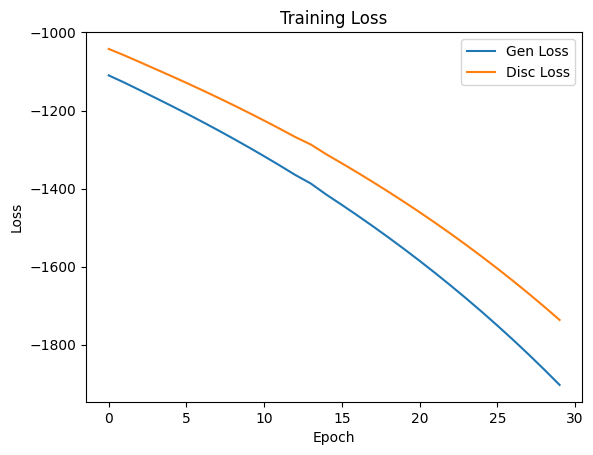

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1)

axes.set_title('Training Loss')
axes.plot(epoch_gen_history, label='Gen Loss')
axes.plot(epoch_disc_history, label='Disc Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

plt.legend()

plt.plot()


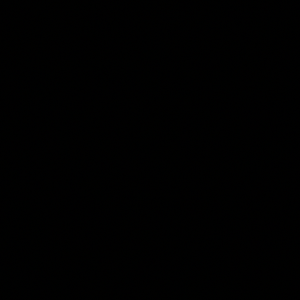

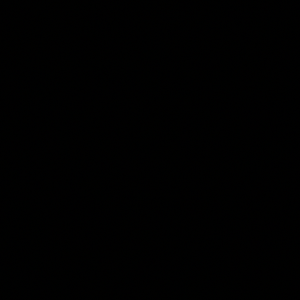

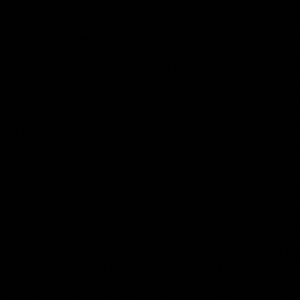

In [56]:
from torchvision.transforms.functional import to_pil_image

model.eval()

result = model.generator(torch.rand(3, 100).to(device))

display(to_pil_image(result[0]))
display(to_pil_image(result[1]))
display(to_pil_image(result[2]))